In [98]:
import psycopg2
import pandas as pd
from sqlalchemy import create_engine, Integer, Numeric, String, Date, DateTime, Boolean, Float
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

# Collect data from database

In [99]:
def get_data_sql(table_name, database, password, user, host='localhost', port=5432):
    """
    Get column names and data types for a PostgreSQL table.

    Parameters:
    -----------
    table_name : str
        The name of the PostgreSQL table.

    database : str
        The name of the database.

    password : str
        The password for the database user.

    user : str
        The username for the database user.

    host : str
        The host where the PostgreSQL server is running (default is 'localhost').

    port : int 
        The port on which the PostgreSQL server is listening (default is 5432).

    Returns:
    --------
    column_info : dict
        A dictionary containing column names and their data types sqlalchemy.
    """
    try:
        # Establish a connection to the database
        conn = psycopg2.connect(host=host, dbname=database, password=password, user=user, port=port)

        # Create a cursor
        cursor = conn.cursor()

        # Execute a query to get table metadata
        query = f"SELECT column_name, data_type FROM information_schema.columns WHERE table_name = '{table_name}'"
        cursor.execute(query)

        # Fetch data into a dictionary
        column_info = {col[0]: col[1] for col in cursor.fetchall()}

        # Close the cursor and connection
        cursor.close()
        conn.close()

        type_mapping = {
            'integer': Integer,
            'numeric': Numeric,
            'character varying': String,
            'date': Date,
            'timestamp without time zone': DateTime,
            'boolean': Boolean,
            'float': Float
        }

        # change datatype pandas to sqlalchemy
        column_info = {key: type_mapping[value] for key, value in column_info.items()}
        
        return column_info

    except psycopg2.Error as e:
        # Print the error and return None
        print(f"Error connecting to the database: {e}")
        return None
    
def collect_sql(select_query, table_name, database, user, password, host='localhost', port=5432):
    """
    Function for collecting data from the database and converting it to a pdDataFrame
    
    Parameters :
    ------------
    select_query : str
        SQL query for selecting data in the database
    
    Returns :
    -------
    df_duplicate : pd.DataFrame
        DataFrame containing the selected data without duplicates
    """
    try:
        # Get column information
        column_info = get_data_sql(table_name=table_name, database=database, user=user, password=password, host=host, port=port)

        # Establish a connection to the database
        conn = psycopg2.connect(host=host, dbname=database, password=password, user=user, port=port)

        # Create a cursor
        curr = conn.cursor()

        # Execute the SQL query
        curr.execute(select_query)

        # Fetch data into a Pandas DataFrame
        columns = [desc[0] for desc in curr.description]
        data = curr.fetchall()

        # Create the DataFrame
        df = pd.DataFrame(data, columns=columns)
        df_duplicate = df.drop_duplicates(keep='first')

        print('Before Drop Data Duplicate', df.shape)
        print('After Drop Data Duplicate', df_duplicate.shape)

        # Close the cursor and connection
        curr.close()
        conn.close()

        return df_duplicate, column_info

    except psycopg2.Error as e:
        # Print the error and return None
        print(f"Error connecting to the database: {e}")
        return None

In [100]:
df, _ = collect_sql(select_query="SELECT * FROM customer_trends_cl", database='clean_data', 
                table_name='customer_trends_cl', password='nifi', 
                user='nifi', host='localhost', port=5432)
df.head()

Before Drop Data Duplicate (18521, 20)
After Drop Data Duplicate (18521, 20)


,transaction_id,customerid,gender,location,tenure_months,transaction_date,product_sku,product_description,product_category,quantity,avg_price,delivery_charges,coupon_status,gst,date,offline_spend,online_spend,month,coupon_code,discount_pct
0,37069,12553,F,Chicago,8,2019-08-31,GGOEGOLC014299,Google Metallic Notebook Set,Office,15,4.79,30.35,Used,0.10,8/31/2019,3000.00,1296.81,8,OFF20,20.00
1,36286,17965,F,Chicago,7,2019-08-22,GGOEGOCB017499,Leatherette Journal,Office,30,6.15,61.13,Used,0.10,8/22/2019,2500.00,1172.96,8,OFF20,20.00
2,36320,13488,F,California,22,2019-08-22,GGOEGOLC014299,Google Metallic Notebook Set,Office,40,4.79,85.33,Used,0.10,8/22/2019,2500.00,1172.96,8,OFF20,20.00
3,36323,13488,F,California,22,2019-08-22,GGOEGFKQ020799,Google Doodle Decal,Office,300,2.39,50.93,Clicked,0.10,8/22/2019,2500.00,1172.96,8,OFF20,20.00
4,36334,13488,F,California,22,2019-08-22,GGOEGGOA017399,Maze Pen,Office,50,0.99,6.00,Clicked,0.10,8/22/2019,2500.00,1172.96,8,OFF20,20.00


# Data Wrangling

In [101]:
# Drop columns
df = df.drop(columns=['date', 'month'], axis = 1)

In [102]:
# Check missing nulls
df.isnull().sum()

transaction_id           0
customerid               0
gender                   0
location                 0
tenure_months            0
transaction_date         0
product_sku              0
product_description      0
product_category         0
quantity                 0
avg_price                0
delivery_charges         0
coupon_status            0
gst                      0
offline_spend            0
online_spend             0
coupon_code            175
discount_pct           175
dtype: int64

In [103]:
# Drop missing nulls
df.fillna(0, inplace=True)

In [104]:
# Sanicheck
df.isnull().sum()

transaction_id         0
customerid             0
gender                 0
location               0
tenure_months          0
transaction_date       0
product_sku            0
product_description    0
product_category       0
quantity               0
avg_price              0
delivery_charges       0
coupon_status          0
gst                    0
offline_spend          0
online_spend           0
coupon_code            0
discount_pct           0
dtype: int64

In [105]:
# Show data
df.head()

,transaction_id,customerid,gender,location,tenure_months,transaction_date,product_sku,product_description,product_category,quantity,avg_price,delivery_charges,coupon_status,gst,offline_spend,online_spend,coupon_code,discount_pct
0,37069,12553,F,Chicago,8,2019-08-31,GGOEGOLC014299,Google Metallic Notebook Set,Office,15,4.79,30.35,Used,0.10,3000.00,1296.81,OFF20,20.00
1,36286,17965,F,Chicago,7,2019-08-22,GGOEGOCB017499,Leatherette Journal,Office,30,6.15,61.13,Used,0.10,2500.00,1172.96,OFF20,20.00
2,36320,13488,F,California,22,2019-08-22,GGOEGOLC014299,Google Metallic Notebook Set,Office,40,4.79,85.33,Used,0.10,2500.00,1172.96,OFF20,20.00
3,36323,13488,F,California,22,2019-08-22,GGOEGFKQ020799,Google Doodle Decal,Office,300,2.39,50.93,Clicked,0.10,2500.00,1172.96,OFF20,20.00
4,36334,13488,F,California,22,2019-08-22,GGOEGGOA017399,Maze Pen,Office,50,0.99,6.00,Clicked,0.10,2500.00,1172.96,OFF20,20.00


In [106]:
# Check dtype
df.dtypes

transaction_id          int64
customerid              int64
gender                 object
location               object
tenure_months           int64
transaction_date       object
product_sku            object
product_description    object
product_category       object
quantity                int64
avg_price              object
delivery_charges       object
coupon_status          object
gst                    object
offline_spend          object
online_spend           object
coupon_code            object
discount_pct           object
dtype: object

In [107]:
# Change data type string to integer
df['offline_spend'] = df['offline_spend'].astype(int)
df['online_spend'] = df['online_spend'].astype(int)
df['avg_price'] = df['avg_price'].astype(int)

# Change data type string to dtime
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

In [108]:
# Sanichek
df.dtypes

transaction_id                  int64
customerid                      int64
gender                         object
location                       object
tenure_months                   int64
transaction_date       datetime64[ns]
product_sku                    object
product_description            object
product_category               object
quantity                        int64
avg_price                       int32
delivery_charges               object
coupon_status                  object
gst                            object
offline_spend                   int32
online_spend                    int32
coupon_code                    object
discount_pct                   object
dtype: object

# Statistic Deskriptive Analysis 

In [109]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
transaction_id,18521.0,32051.823498,7396.744941,19376.0,25931.0,31635.0,38336.0,45266.0
customerid,18521.0,15334.305275,1756.219537,12347.0,13880.0,15311.0,16923.0,18283.0
tenure_months,18521.0,25.807030,13.472186,2.0,14.0,26.0,37.0,50.0
quantity,18521.0,4.083203,21.181626,1.0,1.0,1.0,2.0,900.0
avg_price,18521.0,71.435992,67.996653,0.0,11.0,55.0,119.0,349.0
offline_spend,18521.0,2710.431402,792.719458,500.0,2500.0,3000.0,3000.0,4000.0
online_spend,18521.0,1849.644404,767.480836,320.0,1240.0,1783.0,2365.0,4556.0


- Tenure Months:
Distribution: Appears to be right-skewed, with the mean (25.81) greater than the median (26.0).
Central Tendency: Most tenure months are below the mean.

- Quantity:

Distribution: Heavily right-skewed, as the mean (4.08) is much greater than the median (1.0).
Central Tendency: Most transactions involve a small quantity.

- Average Price:

Distribution: Appears to be right-skewed, with the mean (71.44) greater than the median (55.0).
Central Tendency: The average price is influenced by higher values.

- Offline Spend:

Distribution: Potentially right-skewed, as the mean (2,710.43) is greater than the median (3,000.0).
Central Tendency: The majority of offline spending is below the mean.

- Online Spend:

Distribution: Appears to be right-skewed, with the mean (1,849.64) greater than the median (1,783.0).
Central Tendency: Most online spending is below the mean.

The data not consist 1 year

# Cohort Analysis

Cohort Analysis
- Step 1: Month Extraction from InvoiceDate Column
- Step 2: Assigning Cohorts to Each Column
- Step 3: Assigning Cohort Index to each transaction
- Step 4: Calculating number of unique customers in each Group of (CohortDate,Index)
- Step 5: Retention rate Calculation
- Step 6: Visualizing the Above Retention rate

Step 1: Month Extraction from TransactionDate Column

In [110]:
# create month extraction function
def extract_month(date_value):
    """
    Extracts the first day of the month from a given date.

    Parameter:
    ----------
    date_value: pandas dataframe
        The input date

    Returns:
    --------
    datetime: pandas dataframe
        The first day of the month corresponding to the input date
    """
    # Returns a new datetime object with the same year
    # and same month as the input date, but with day set to 1.
    return dt.datetime(date_value.year, date_value.month, 1)

In [111]:
# Creating customer trends column using the function created in previous step
df['Month'] = df['transaction_date'].apply(extract_month)

In [112]:
# read transaction date and transaction month
df[['transaction_date','Month']].head()

,transaction_date,Month
0,2019-08-31,2019-08-01
1,2019-08-22,2019-08-01
2,2019-08-22,2019-08-01
3,2019-08-22,2019-08-01
4,2019-08-22,2019-08-01


Step 2: Assigning Cohorts to Each Column

In [113]:
# groupby Customer ID and show transaction Month
df['CohortMonth'] = df.groupby('customerid')['Month'].transform('min')

In [114]:
# shanity check
df.head()

,transaction_id,customerid,gender,location,tenure_months,transaction_date,product_sku,product_description,product_category,quantity,avg_price,delivery_charges,coupon_status,gst,offline_spend,online_spend,coupon_code,discount_pct,Month,CohortMonth
0,37069,12553,F,Chicago,8,2019-08-31,GGOEGOLC014299,Google Metallic Notebook Set,Office,15,4,30.35,Used,0.10,3000,1296,OFF20,20.00,2019-08-01,2019-08-01
1,36286,17965,F,Chicago,7,2019-08-22,GGOEGOCB017499,Leatherette Journal,Office,30,6,61.13,Used,0.10,2500,1172,OFF20,20.00,2019-08-01,2019-03-01
2,36320,13488,F,California,22,2019-08-22,GGOEGOLC014299,Google Metallic Notebook Set,Office,40,4,85.33,Used,0.10,2500,1172,OFF20,20.00,2019-08-01,2019-03-01
3,36323,13488,F,California,22,2019-08-22,GGOEGFKQ020799,Google Doodle Decal,Office,300,2,50.93,Clicked,0.10,2500,1172,OFF20,20.00,2019-08-01,2019-03-01
4,36334,13488,F,California,22,2019-08-22,GGOEGGOA017399,Maze Pen,Office,50,0,6.00,Clicked,0.10,2500,1172,OFF20,20.00,2019-08-01,2019-03-01


Step 3: Assigning Cohort Index to each transaction

In [115]:
def parse_dates_int(date_series):
    """
    Extracts the year and month components from a pandas Datetime column.

    Parameters
    ----------
    date_series : pandas Series
        A pandas Series containing datetime values.

    Returns
    -------
    tuple
        A tuple of two pandas Series, one for years and one for months.
    """
    return date_series.dt.year, date_series.dt.month


def run_parse_date(data_cohort, date):
    """
    Calculates the cohort index based on the difference in years and months
    between the date of each transaction and the cohort date.

    Parameters
    ----------
    data_cohort : pandas DataFrame
        DataFrame with assigned cohort for each transaction.

    date : datetime
        Name of the column containing transaction dates.

    Returns
    -------
    pandas DataFrame
        DataFrame with an added 'CohortIndex' column representing the number
        of months passed between the transaction date and cohort date.
    """

    # Get the integers for date parts from the `date` column
    year, month = parse_dates_int(data_cohort[date])

    # Get the integers for date parts from the `CohortMonth` column
    cohort_year, cohort_month = parse_dates_int(data_cohort['CohortMonth'])

    """
    - This code below calculates the difference in years and months
    - The difference is between the transaction date and the cohort date.
    - It then uses these differences to calculate a cohort index
    - The index represents the number of months passed between the two dates
    """

    # Calculate difference in years
    years_diff = year - cohort_year

    # Calculate difference in months
    months_diff = month - cohort_month

    # Using the variables created above to calculate the difference in months
    # and storing them in the 'CohortIndex' column
    data_cohort['CohortIndex'] = years_diff * 12 + months_diff + 1

    return data_cohort


In [116]:
data_cohort = run_parse_date(data_cohort = df, date = 'transaction_date')

Step 4: Calculating number of unique customers in each Group of (CohortDate,Index)

In [117]:
def calculate_unique_cust(data_cohort, customer_id):
    """
    Function to calculate unique customers each cohort index

    Parameter
    ---------

    data_cohort : pandas dataframe
        pandas dataframe with assigned cohort index
    
    customer_id : int
        customer_id column contains many uniques id
              
    Returns
    --------
    cohort_data_fin : pandas dataframe
         pandas dataframe with unique customers each cohort index

    """
    # find nunique custoemr ID each cohort month and cohort index
    data_group = data_cohort.groupby(
        ['CohortMonth', 'CohortIndex'])[customer_id].transform('nunique')

    # Grouping the data by 'CohortMonth' and 'CohortIndex'
    grouped = data_cohort.groupby(['CohortMonth', 'CohortIndex'])

    # Counting the number of unique customer IDs in each group
    cohort_counts = grouped[customer_id].nunique()

    # Creating a new DataFrame with cohort data
    cohort_data_fin = cohort_counts.reset_index()

    # rename columns
    cohort_data_fin = cohort_data_fin.rename(
        columns={ customer_id: 'Unique Customer'})

    return cohort_data_fin

In [118]:
# Run function
cohort_data_fin = calculate_unique_cust(data_cohort = data_cohort,  customer_id = 'customerid')

In [119]:
# Check result
cohort_data_fin.head()

,CohortMonth,CohortIndex,Unique Customer
0,2019-02-01,1,103
1,2019-02-01,2,10
2,2019-02-01,3,13
3,2019-02-01,4,18
4,2019-02-01,5,19


 Step 5: Retention rate Calculation

In [120]:
def calculate_cust_retention(cohort_data_fin):
    """
    Function to calculate customer retention

    Parameter
    ---------
    cohort_data_fin: pandas dataframe
        pandas dataframe with assigned cohort index
        and number of unique customer

    Returns
    --------
    retention_rate: pandas dataframe
        pandas dataframe with retention rate each cohort index

    """
    # Creating new dataframe with index as CohortMonth,
    # columns as Cohort indexes and Values as Count
    retention_counts = cohort_data_fin.pivot(index = 'CohortMonth',
                                             columns = 'CohortIndex',
                                             values = 'Unique Customer')

    # Select the first column and store it to cohort_sizes
    cohort_sizes = retention_counts.iloc[:,0]

    # Divide the cohort count by cohort sizes along the rows
    retention_rate = retention_counts.divide(cohort_sizes, axis=0)

    # Convert the index to a string format 'YYYY-MM'
    retention_rate.index = retention_rate.index.strftime('%Y-%m')

    return retention_rate

In [121]:
# Run function
retention_rate_data = calculate_cust_retention(cohort_data_fin)

In [122]:
# Check result
retention_rate_data.head()

CohortIndex,1,2,3,4,5,6,7,8,9,10
CohortMonth,,,,,,,,,,
2019-02,1.0,0.097087,0.126214,0.174757,0.184466,0.252427,0.213592,0.194175,0.165049,0.135922
2019-03,1.0,0.081522,0.168478,0.130435,0.173913,0.179348,0.114130,0.097826,0.065217,NaN
2019-04,1.0,0.079268,0.140244,0.121951,0.109756,0.097561,0.060976,0.091463,NaN,NaN
2019-05,1.0,0.084746,0.110169,0.110169,0.084746,0.118644,0.127119,NaN,NaN,NaN
2019-06,1.0,0.121019,0.133758,0.095541,0.108280,0.108280,NaN,NaN,NaN,NaN


**Putting it all Together**

In [123]:
def create_retention_df(data_cohort):
    """
    Calculate customer retention rate based on cohort analysis.

    Parameters
    ----------
    data_cohort : pandas DataFrame
        DataFrame containing raw data with transaction information.

    date : datetime
        Name of the column containing transaction dates.

    customer_id : str
        Name of the column containing customer IDs.

    Returns
    -------
    retention_rate : pandas DataFrame
        DataFrame with retention rates for each cohort index.
    """
    # Step 1: Create 'Month' column using the 'extract_month' function
    data_cohort['Month'] = data_cohort['transaction_date'].apply(extract_month)

    # Step 2: Group by Customer ID and show Invoice Month
    data_cohort['CohortMonth'] = data_cohort.groupby('customerid')['Month'].transform('min')

    # Step 3: Assign Cohort index to each transaction
    data_cohort = run_parse_date(data_cohort, 'transaction_date')

    # Step 4: Calculate the number of unique customers in each cohort group
    cohort_data_fin = calculate_unique_cust(data_cohort, 'customerid')

    # Step 5: Calculate retention rate
    retention_rate_data = calculate_cust_retention(cohort_data_fin)

    return retention_rate_data

In [124]:
# Run function
retention = create_retention_df(data_cohort = data_cohort)

In [125]:
# Check result
retention

CohortIndex,1,2,3,4,5,6,7,8,9,10
CohortMonth,,,,,,,,,,
2019-02,1.0,0.097087,0.126214,0.174757,0.184466,0.252427,0.213592,0.194175,0.165049,0.135922
2019-03,1.0,0.081522,0.168478,0.130435,0.173913,0.179348,0.114130,0.097826,0.065217,NaN
2019-04,1.0,0.079268,0.140244,0.121951,0.109756,0.097561,0.060976,0.091463,NaN,NaN
2019-05,1.0,0.084746,0.110169,0.110169,0.084746,0.118644,0.127119,NaN,NaN,NaN
2019-06,1.0,0.121019,0.133758,0.095541,0.108280,0.108280,NaN,NaN,NaN,NaN
2019-07,1.0,0.121212,0.020202,0.030303,0.131313,NaN,NaN,NaN,NaN,NaN
2019-08,1.0,0.080292,0.080292,0.065693,NaN,NaN,NaN,NaN,NaN,NaN
2019-09,1.0,0.066667,0.080000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10,1.0,0.095238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Step 6: Visualizing the Above Retention rate

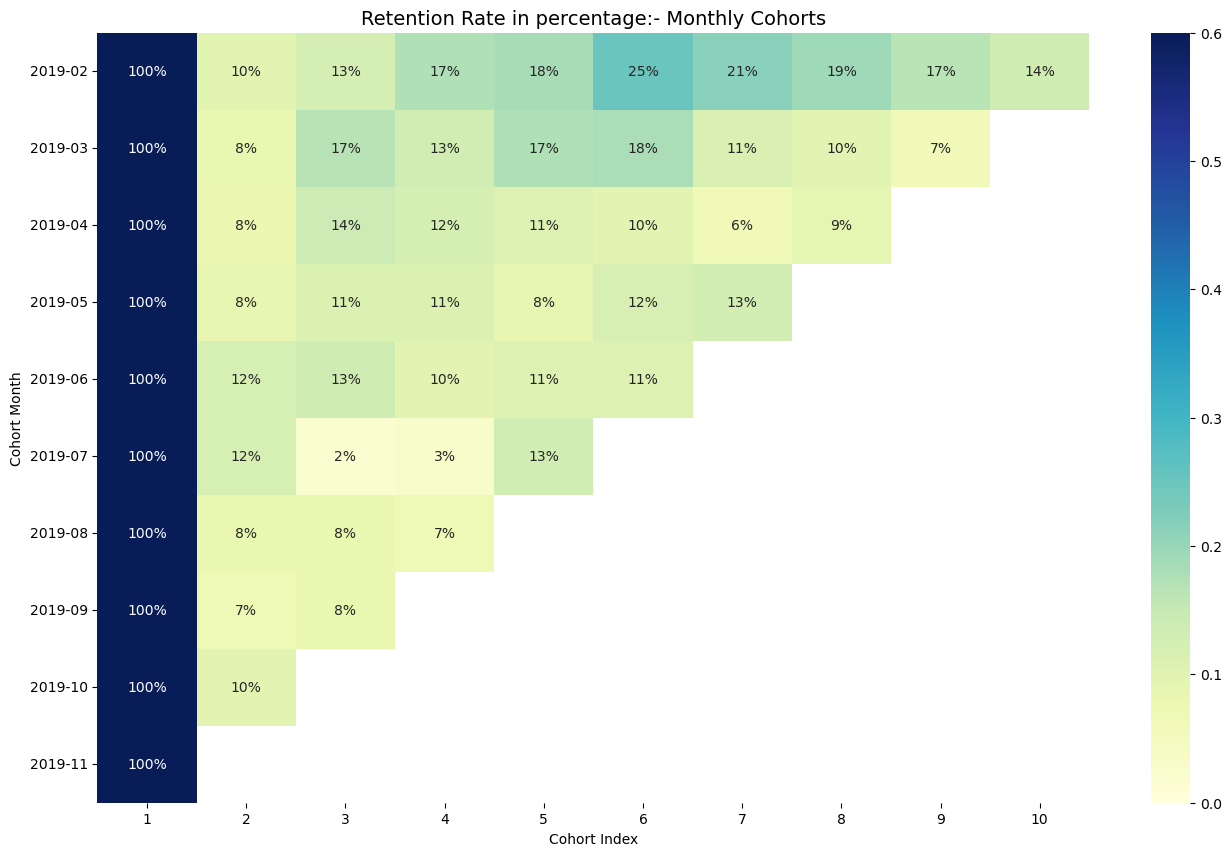

In [206]:
# Initialize the figure
plt.figure(figsize=(16, 10))

# Adding a title
plt.title('Retention Rate in percentage:- Monthly Cohorts', fontsize = 14)

# Creating the heatmap
sns.heatmap(retention, annot=True, fmt= '.0%',cmap='YlGnBu', vmin = 0.0 , vmax = 0.6)
plt.ylabel('Cohort Month')
plt.xlabel('Cohort Index')
plt.yticks( rotation='horizontal')
plt.show()

- Obtain the best retention rate of 25% from customers in index 6, but decrease until 6 months and go away in the next month.

In [127]:
# Calculate average monthly retention rate
retention_rate = retention.iloc[:,1:].mean().mean()

In [128]:
# print average monthy retention rate
print(f"Average Monthly Retention Rate of All Customers : {retention_rate*100:.2f} %")

# define churn rate
churn_rate = 1 - retention_rate

# print churn rate
print(f"Average Monthly Churn Rate of All Customers : {churn_rate*100:.2f} %")

Average Monthly Retention Rate of All Customers : 12.16 %
Average Monthly Churn Rate of All Customers : 87.84 %


# Churn Analysis with RFM

## Data Splitting

In [129]:
print(f"First Transaction : {df['transaction_date'].min()}")
print(f"Last Transaction : {df['transaction_date'].max()}")

First Transaction : 2019-02-01 00:00:00
Last Transaction : 2019-11-30 00:00:00


- Make observation period log
- We need to see transaction log each weeks each customer
- Then we can define how to split the data (observation data/historical and future data)
- We need data stamped (transactional data) and data log transaction week

In [130]:
def create_observation_period_log(data):
    """
    Create the weekly observation period log table
    based on the provided DataFrame.

    Parameter
    ---------
    data: pandas DataFrame
        Input DataFrame containing transaction data.

    Return
    ------
    data_log: pandas DataFrame
        Weekly observation period log table with
        customers as rows and weeks as columns.

    data_stamped : pandas DataFrame
        Sample data with week information
    """
    data = data.copy()

    # Group the data by customer and week
    data['Week'] = data['transaction_date'].dt.isocalendar().week
    data['WeekStart'] = data['transaction_date'].dt.to_period('W').dt.start_time
    data['WeekEnd'] = data['transaction_date'].dt.to_period('W').dt.end_time

    # Obtain unique customer & unique week
    unique_cust = sorted(set(data['customerid']))
    unique_week = sorted(set(data['Week']))

    # Create the weekly observation period log table
    data_log = pd.DataFrame(np.zeros((len(unique_cust), len(unique_week)), dtype=int))
    data_log.index = unique_cust
    data_log.columns = unique_week

    # Iterate over each customer group
    for customer_id, group in data.groupby('customerid'):
        # Obtain the week where customer do transactions
        week_purchase = list(set(group['Week']))

        # Fill the data log
        data_log.loc[customer_id, week_purchase] = 1

    data_stamped = data

    return data_log, data_stamped

In [131]:
data_log, data_stamped = create_observation_period_log(df)

In [132]:
# shanity check
print(data_log.shape)
data_log.head()

(1189, 44)


,5,6,7,8,9,10,11,12,13,14,...,39,40,41,42,43,44,45,46,47,48
12347,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
12348,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
12356,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12359,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12370,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [133]:
# shanity check
print(data_stamped.shape)
data_stamped.head()

(18521, 24)


,transaction_id,customerid,gender,location,tenure_months,transaction_date,product_sku,product_description,product_category,quantity,...,offline_spend,online_spend,coupon_code,discount_pct,Month,CohortMonth,CohortIndex,Week,WeekStart,WeekEnd
0,37069,12553,F,Chicago,8,2019-08-31,GGOEGOLC014299,Google Metallic Notebook Set,Office,15,...,3000,1296,OFF20,20.00,2019-08-01,2019-08-01,1,35,2019-08-26,2019-09-01 23:59:59.999999999
1,36286,17965,F,Chicago,7,2019-08-22,GGOEGOCB017499,Leatherette Journal,Office,30,...,2500,1172,OFF20,20.00,2019-08-01,2019-03-01,6,34,2019-08-19,2019-08-25 23:59:59.999999999
2,36320,13488,F,California,22,2019-08-22,GGOEGOLC014299,Google Metallic Notebook Set,Office,40,...,2500,1172,OFF20,20.00,2019-08-01,2019-03-01,6,34,2019-08-19,2019-08-25 23:59:59.999999999
3,36323,13488,F,California,22,2019-08-22,GGOEGFKQ020799,Google Doodle Decal,Office,300,...,2500,1172,OFF20,20.00,2019-08-01,2019-03-01,6,34,2019-08-19,2019-08-25 23:59:59.999999999
4,36334,13488,F,California,22,2019-08-22,GGOEGGOA017399,Maze Pen,Office,50,...,2500,1172,OFF20,20.00,2019-08-01,2019-03-01,6,34,2019-08-19,2019-08-25 23:59:59.999999999


We will set data_log_historical and data_log_future as follows:
- data_log_historical : week 5-30 and we will use week 31-35 as time window
- data_log_future : week 5-40 and we will use week 41-48 as time window
- We will use `data_log_historical` create training set, valid set, and testing set

In [134]:
def split_historical_future_data(data_log, time_sep):
    """
    Split the observation period log data into training & testing sets

    Parameters
    ----------
    data_log : pandas DataFrame
          Sample of data log

    time_sep : str
          Time separator to separate the data,
          in 'YYYY-MM-DD' format

    Returns
    -------
    data_log_train : pandas DataFrame
          Sample of train data log

    data_log_test : pandas DataFrame
          Sample of test data log
    """
    # Set time separator
    time_separator = pd.to_datetime(time_sep)

    # Convert time separator to week separator
    condition_sep = data_stamped['transaction_date'] < time_separator
    week_separator = data_stamped[condition_sep]['Week'].max()

    # Split train & test data log
    data_log_historical = data_log.loc[:, :week_separator]
    data_log_future = data_log.loc[:,:]

    print('Data log historical shape     :', data_log_historical.shape)
    print('Data log future shape      :', data_log_future.shape)

    return data_log_historical, data_log_future

In [135]:
data_log_historical, data_log_future = split_historical_future_data(data_log = data_log,
                                                                    time_sep = '2019-08-28') # approximately week 35

Data log historical shape     : (1189, 31)
Data log future shape      : (1189, 44)


In [136]:
data_log_historical.head()

,5,6,7,8,9,10,11,12,13,14,...,26,27,28,29,30,31,32,33,34,35
12347,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
12348,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12356,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12359,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
12370,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [137]:
# check customer with 1 minimum transaction
print(f"Number of all customers: {data_log_historical.shape[0]}")
print(f"Number of customer with transaction event in historical log: {data_log_historical[data_log_historical.sum(axis=1)>0].shape[0]}")

Number of all customers: 1189
Number of customer with transaction event in historical log: 965


In [138]:
data_log_future.head()

,5,6,7,8,9,10,11,12,13,14,...,39,40,41,42,43,44,45,46,47,48
12347,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
12348,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
12356,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12359,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12370,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [139]:
# check customer with 1 minimum transaction
print(f"Number of all customers: {data_log_future.shape[0]}")
print(f"Number of customer with transaction event in future log: {data_log_future[data_log_future.sum(axis=1)>0].shape[0]}")

Number of all customers: 1189
Number of customer with transaction event in future log: 1189


**Define our customer in train data & its churn status**

Our customer is defined as:
- customer who bought once before churn observation period
- churn observation (from historical log) period: week 5-30
- We will use week 31-35 to define customer churn

In [140]:
def log_period_separation(log_data, obs_period, time):
    """
    Function to separate log period data and data for anotation

    Parameters
    ----------
    log_data: pandas dataframe
          log data for each week purchase event

    obs_period: int
          churn observation period (time window) in weeks

    time: str
          time separator

    returns
    -------
    log_period_data: pandas dataframe
          log period data for observation

    data_for_anotation: pandas dataframe
          data for defining churn (time window)
    """
    # define time separator
    time_sep = pd.to_datetime(time)
    cond_sep = data_stamped['transaction_date'] < time_sep
    week_sep = data_stamped[cond_sep]['Week'].max()

    # filter data
    data_log_filtered = log_data[log_data.sum(axis=1)>0]

    # separate data
    data_log_obs =  data_log_filtered.iloc[:, :week_sep-obs_period]
    data_for_anotation = data_log_filtered.iloc[:, week_sep-obs_period:]

    return data_log_obs, data_for_anotation

In [141]:
log_period_his_data, data_his_for_anotation = log_period_separation(log_data = data_log_historical,
                                                                    obs_period = 9,
                                                                    time = '2019-08-29')

In [142]:
# historical data log_period
log_period_his_data.head()

,5,6,7,8,9,10,11,12,13,14,...,21,22,23,24,25,26,27,28,29,30
12347,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
12348,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
12359,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12370,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
12377,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [143]:
# historical data for anotation
data_his_for_anotation

,31,32,33,34,35
12347,0,0,0,0,0
12348,0,0,0,0,0
12359,0,0,0,1,0
12370,0,0,0,0,0
12377,0,0,0,0,0
...,...,...,...,...,...
18245,0,0,0,0,0
18256,0,0,0,0,0
18259,0,0,0,0,0
18260,0,1,0,0,0


In [144]:
def assign_customer_id(data_log, data_stamped, date):
    """
    Function to assign customer id

    Parameters
    ----------
    data_log: pandas dataframe
            log data with each week as the columns

    data_stamped: pandas dataframe
            transactional data

    Returns
    -------
    transaction_df: pandas dataframe
            transactional daa with filtered customers
    """
    # get customer id
    unique_cust = data_log.index.tolist()

    # filter data based on the date
    data_filtered = data_stamped[data_stamped['transaction_date']<date]

    # filter data
    transaction_df = data_filtered[(data_filtered['customerid'].isin(unique_cust))]

    return transaction_df

In [145]:
transaction_df = assign_customer_id(data_log = log_period_his_data,
                                    data_stamped = data_stamped,
                                    date = '2019-08-29')

In [146]:
# shanity check
print(transaction_df.shape)
transaction_df.head()

(12764, 24)


,transaction_id,customerid,gender,location,tenure_months,transaction_date,product_sku,product_description,product_category,quantity,...,offline_spend,online_spend,coupon_code,discount_pct,Month,CohortMonth,CohortIndex,Week,WeekStart,WeekEnd
1,36286,17965,F,Chicago,7,2019-08-22,GGOEGOCB017499,Leatherette Journal,Office,30,...,2500,1172,OFF20,20.00,2019-08-01,2019-03-01,6,34,2019-08-19,2019-08-25 23:59:59.999999999
2,36320,13488,F,California,22,2019-08-22,GGOEGOLC014299,Google Metallic Notebook Set,Office,40,...,2500,1172,OFF20,20.00,2019-08-01,2019-03-01,6,34,2019-08-19,2019-08-25 23:59:59.999999999
3,36323,13488,F,California,22,2019-08-22,GGOEGFKQ020799,Google Doodle Decal,Office,300,...,2500,1172,OFF20,20.00,2019-08-01,2019-03-01,6,34,2019-08-19,2019-08-25 23:59:59.999999999
4,36334,13488,F,California,22,2019-08-22,GGOEGGOA017399,Maze Pen,Office,50,...,2500,1172,OFF20,20.00,2019-08-01,2019-03-01,6,34,2019-08-19,2019-08-25 23:59:59.999999999
5,36233,13458,F,California,33,2019-08-22,GGOEGOCB017499,Leatherette Journal,Office,8,...,2500,1172,OFF20,20.00,2019-08-01,2019-06-01,3,34,2019-08-19,2019-08-25 23:59:59.999999999


In [147]:
# shanity check
transaction_df['transaction_date'].max()

Timestamp('2019-08-28 00:00:00')

In [148]:
def remove_unnecessary_cols(data):
    """
    Function to remove unnuecessary cols

    Parameter
    ---------
    data : pandas dataframe
        transactional data

    Return
    data_cust : pandas dataframe
        data with removed unnecessary cols
    """
    # remove unnecessary columns
    data_cust = data.drop(columns=['Week', 'WeekStart', 'WeekEnd', 'CohortMonth', 'CohortIndex'])

    return data_cust

In [149]:
transaction_data = remove_unnecessary_cols(data = transaction_df)

In [150]:
# shanity check
print(transaction_data.shape)
transaction_data.head()

(12764, 19)


,transaction_id,customerid,gender,location,tenure_months,transaction_date,product_sku,product_description,product_category,quantity,avg_price,delivery_charges,coupon_status,gst,offline_spend,online_spend,coupon_code,discount_pct,Month
1,36286,17965,F,Chicago,7,2019-08-22,GGOEGOCB017499,Leatherette Journal,Office,30,6,61.13,Used,0.10,2500,1172,OFF20,20.00,2019-08-01
2,36320,13488,F,California,22,2019-08-22,GGOEGOLC014299,Google Metallic Notebook Set,Office,40,4,85.33,Used,0.10,2500,1172,OFF20,20.00,2019-08-01
3,36323,13488,F,California,22,2019-08-22,GGOEGFKQ020799,Google Doodle Decal,Office,300,2,50.93,Clicked,0.10,2500,1172,OFF20,20.00,2019-08-01
4,36334,13488,F,California,22,2019-08-22,GGOEGGOA017399,Maze Pen,Office,50,0,6.00,Clicked,0.10,2500,1172,OFF20,20.00,2019-08-01
5,36233,13458,F,California,33,2019-08-22,GGOEGOCB017499,Leatherette Journal,Office,8,6,21.19,Not Used,0.10,2500,1172,OFF20,20.00,2019-08-01


In [217]:
# copy train_set data
eda = transaction_data.copy()
eda.shape

(12764, 19)

In [218]:
eda_anotation_data = data_his_for_anotation.copy()
eda_anotation_data.shape

(965, 5)

## Customer Churn Definition

- Customer who has purchase event before defined time window
- Customer who has no purchase event in defined 5 weeks time window

## Find Churn Base On RFM

- **Recency** (R) <br>
Recency refers to the time elapsed since a customer's last interaction or transaction with a company.
It measures **how recently a customer has engaged** with the business

- **Frequency** (F)<br>
Frequency represents the number of transaction occurs.
It measures how often a customer engages with the business.

- **Monetary** (M)<br>
Monetary refers to the total monetary value of a customer's transactions or purchases.

- **Tenure** (T) <br>
The length of time a customer remains a customer **until the latest date**

In [153]:
print(f"First Transaction : {eda['transaction_date'].min()}")
print(f"Last Transaction : {eda['transaction_date'].max()}")

First Transaction : 2019-02-01 00:00:00
Last Transaction : 2019-08-28 00:00:00


 Create RFM, Tenure, and AOV Variable

In [154]:
# Define some functions

def calculate_recency(x):
    """Calculate the recency (days) based on the reference date"""
    # we set reference date as last purchase date based on the input data
    return (reference_date - x.max()).days

def calculate_tenure(x):
    """Calculate the tenure (days) based on the reference date"""
    return (x.max() - x.min()).days

def calculate_frequency(x):
    """Calculate the frequency based on the latest date"""
    return len(set(x))

def calculate_monetary(x):
    """Calculate the total monetary value"""
    return x.sum()

def calculate_avg_order_value(x):
    """Calculate the average order value"""
    return np.round(x.sum() / len(set(x)), 2)

def generate_rfmts(data, reference_date):
    """
    Function to generate the RFM + TS data

    Parameter
    ---------
    data : pandas Dataframe
        The sample data

    Return
    ------
    rfmts_data : pandas Dataframe
        The RFM + TS data
    """
    # 1. Create sales data --> sales = quantity x price
    data['Sales'] = data['quantity'] * data['avg_price']

    # 2. Groupby by `Customer ID` to generate the RFM + TS data
    agg_dict = {
        'transaction_date': [calculate_recency, calculate_tenure],
        'customerid': calculate_frequency,
        'Sales': [calculate_monetary, calculate_avg_order_value]
    }
    data_rfmts = data.groupby('customerid').agg(agg_dict)

    # 3. Rename columns
    data_rfmts.columns = ['Recency', 'Tenure', 'Frequency', 'Monetary', 'AOV']

    # 4. Change index type
    data_rfmts.index = data_rfmts.index.astype('int')

    return data_rfmts

In [155]:
# define reference date (max purchase date)
reference_date = eda['transaction_date'].max()

In [156]:
eda_rfm_data = generate_rfmts(data = eda,
                              reference_date = reference_date)

# Validate
# rows of eda_rfm_data == number of unique customer ID
assert eda_rfm_data.shape[0] == len(set(eda['customerid']))
print('RFM data shape :', eda_rfm_data.shape)

RFM data shape : (950, 5)


In [157]:
# shanity check
eda_rfm_data.head()

,Recency,Tenure,Frequency,Monetary,AOV
customerid,,,,,
12347,157,0,1,2924,243.67
12348,67,0,1,275,68.75
12359,5,0,1,13,13.00
12370,64,30,1,4302,179.25
12377,54,0,1,1468,133.45


- Customer 12347 exhibits a significant Tenure and a high Average Order Value (AOV), indicating loyalty and a propensity to make purchases with substantial order values.
- Customer 12348 has a reasonably good Tenure, although Frequency and AOV are relatively lower.
- Customers 12356 and 12359 have recently started shopping, showing a noteworthy AOV, but there is no information available about Frequency.
- Customer 12370 boasts an exceptionally high Tenure, coupled with a high Frequency and AOV, signifying a long-term relationship with substantial order values.

In [158]:
# check descriptive stats
eda_rfm_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,950.0,80.195789,57.721084,0.0,28.250,70.0,131.0000,208.0
Tenure,950.0,27.650526,51.110739,0.0,0.000,0.0,29.0000,198.0
Frequency,950.0,1.000000,0.000000,1.0,1.000,1.0,1.0000,1.0
Monetary,950.0,1363.874737,2156.131618,1.0,210.250,705.5,1691.0000,36181.0
AOV,950.0,119.730474,85.610076,1.0,56.425,112.5,166.2525,851.0


## Define Churn Variable

In [159]:
eda_rfm_data.shape

(950, 5)

In [160]:
# check data anot
print(eda_anotation_data.shape)
eda_anotation_data.head()

(965, 5)


,31,32,33,34,35
12347,0,0,0,0,0
12348,0,0,0,0,0
12359,0,0,0,1,0
12370,0,0,0,0,0
12377,0,0,0,0,0


In [161]:
def filter_anotation_customer(data_anotation, data_transaction):
    """
    Function to filter anotation customer id data

    Parameters:
    -----------

    data_anotation : pandas dataframe
                  data that we will use for anotation

    data_transaction : pandas dataframe
                  transactional data (user data)

    Return:
    -------
    data_anot_filtered : pandas dataframe
                  data anotation filtered with user list from transaction data
    """

    # get customer id
    list_cust = data_transaction.index.to_list()

    # assign customer id
    data_anot_filtered = data_anotation[data_anotation.index.isin(list_cust)]

    return data_anot_filtered

In [162]:
eda_anot_filtered = filter_anotation_customer(data_anotation = eda_anotation_data,
                                              data_transaction = eda_rfm_data)

In [163]:
# shanity check
print(eda_anot_filtered.shape)
eda_anot_filtered.head()

(950, 5)


,31,32,33,34,35
12347,0,0,0,0,0
12348,0,0,0,0,0
12359,0,0,0,1,0
12370,0,0,0,0,0
12377,0,0,0,0,0


In [164]:
def create_churn_anotation(anotation_data):
    """
    Function to create churn variable

    Parameters
    ----------

    anotation_data: pandas dataframe
                  data for anotation for creating churn variable

    Return
    ------

    anotation_data['churn'] : pandas series
                  churn variable
    """
    # find number of transaction
    anotation_data['n_transaction'] = np.sum(anotation_data, axis=1)

    # label churn
    anotation_data['churn'] = np.where(anotation_data['n_transaction'] == 0, 1, 0)

    return anotation_data['churn']

In [165]:
eda_churn = create_churn_anotation(anotation_data = eda_anotation_data)

In [166]:
eda_churn.value_counts()

1    694
0    271
Name: churn, dtype: int64

In [167]:
# concate
eda_rfm_data['churn'] = eda_churn

In [168]:
# shanity check
print(eda_rfm_data.shape)
eda_rfm_data.head()

(950, 6)


,Recency,Tenure,Frequency,Monetary,AOV,churn
customerid,,,,,,
12347,157,0,1,2924,243.67,1
12348,67,0,1,275,68.75,1
12359,5,0,1,13,13.00,0
12370,64,30,1,4302,179.25,1
12377,54,0,1,1468,133.45,1


## Explore RFM churn

In [169]:
# check descriptive stats
eda_rfm_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,950.0,80.195789,57.721084,0.0,28.250,70.0,131.0000,208.0
Tenure,950.0,27.650526,51.110739,0.0,0.000,0.0,29.0000,198.0
Frequency,950.0,1.000000,0.000000,1.0,1.000,1.0,1.0000,1.0
Monetary,950.0,1363.874737,2156.131618,1.0,210.250,705.5,1691.0000,36181.0
AOV,950.0,119.730474,85.610076,1.0,56.425,112.5,166.2525,851.0
churn,950.0,0.730526,0.443920,0.0,0.000,1.0,1.0000,1.0


- We need to check the distribution using plot
- It seems there're some outliers in Frequency, Monetary, and AOV
- Tenure 0 means the customer only buy once in their lifetime with the company (1 time purchaser)

### Recency

In [170]:
# show descriptive stats
eda_rfm_data['Recency'].describe()

count    950.000000
mean      80.195789
std       57.721084
min        0.000000
25%       28.250000
50%       70.000000
75%      131.000000
max      208.000000
Name: Recency, dtype: float64

Text(0.5, 1.0, 'Recency Distribution')

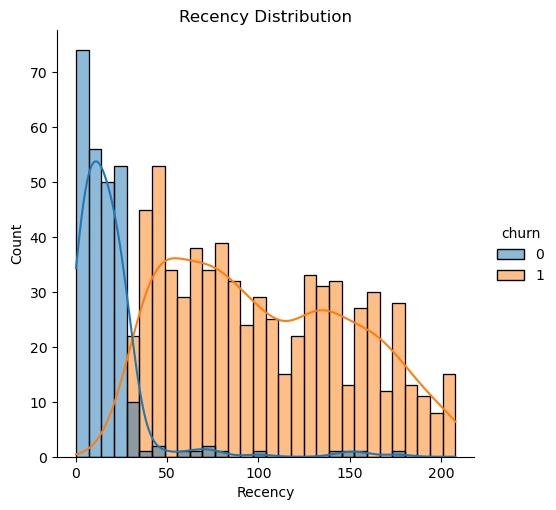

In [171]:
# check distribution
sns.displot(data=eda_rfm_data, x='Recency', hue='churn', kde=True, bins=30)
plt.title('Recency Distribution')

- Most of our customers are recent buyers
- It's also including the one time buyers

### Tenure

In [172]:
# show descriptive stats
eda_rfm_data['Tenure'].describe()

count    950.000000
mean      27.650526
std       51.110739
min        0.000000
25%        0.000000
50%        0.000000
75%       29.000000
max      198.000000
Name: Tenure, dtype: float64

Text(0.5, 1.0, 'Tenure Distribution')

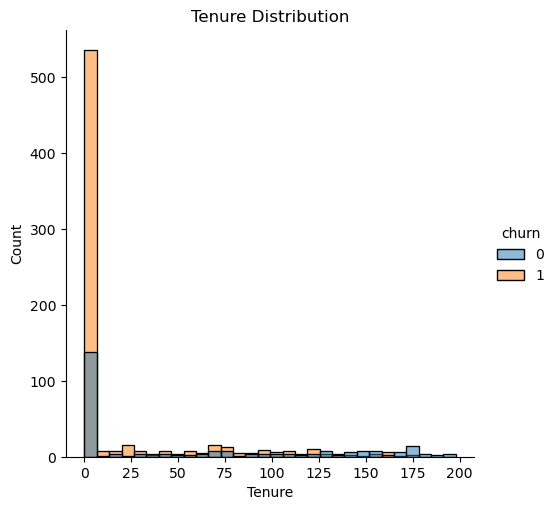

In [173]:
# check distribution
sns.displot(eda_rfm_data, x='Tenure', hue='churn', bins=30)
plt.title('Tenure Distribution')

- Tenure 0 means one time purchaser
- Most of our customers are one time purchaser
- And most of the one time purchaser is churn

In [174]:
# show tenure when the frequency is 1
eda_rfm_data[eda_rfm_data['Frequency'] == 1]['Tenure'].value_counts()

0      579
1       87
70       6
71       5
69       5
      ... 
68       1
23       1
107      1
102      1
83       1
Name: Tenure, Length: 154, dtype: int64

### Frequency

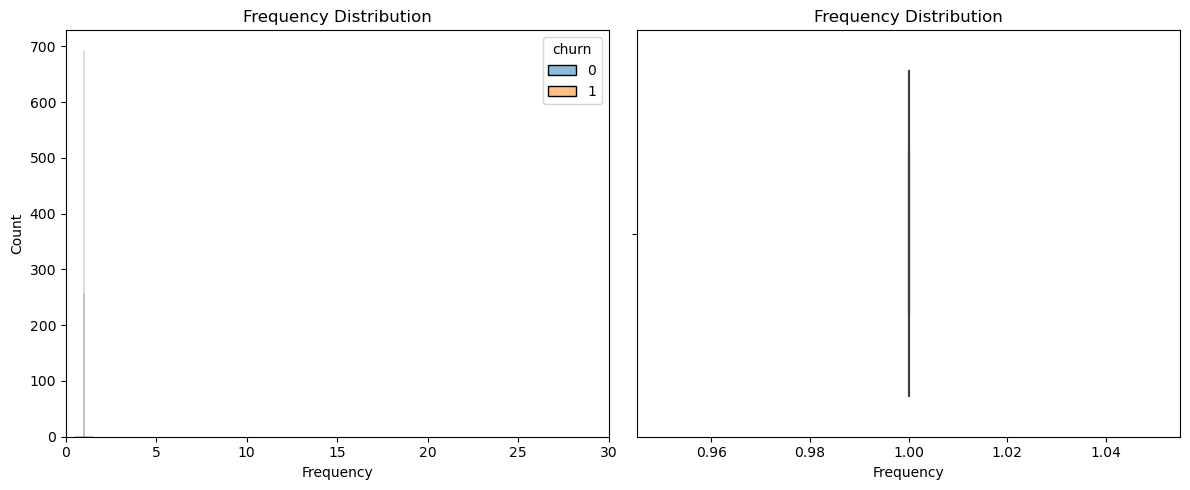

In [175]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Frequency Distribution
sns.histplot(eda_rfm_data, x='Frequency', hue='churn', bins=150, ax=axes[0])
axes[0].set_title('Frequency Distribution')
axes[0].set_xlim(0, 30)

# Plot 2: Boxplot
sns.boxplot(x='Frequency', data=eda_rfm_data, ax=axes[1])
axes[1].set_title('Frequency Distribution')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

In [176]:
# show Churn when the frequency is 1
eda_rfm_data[eda_rfm_data['Frequency'] == 1]['churn'].value_counts(normalize=True)*100

1    73.052632
0    26.947368
Name: churn, dtype: float64

### Monetery

In [177]:
eda_rfm_data['Monetary'].describe()

count      950.000000
mean      1363.874737
std       2156.131618
min          1.000000
25%        210.250000
50%        705.500000
75%       1691.000000
max      36181.000000
Name: Monetary, dtype: float64

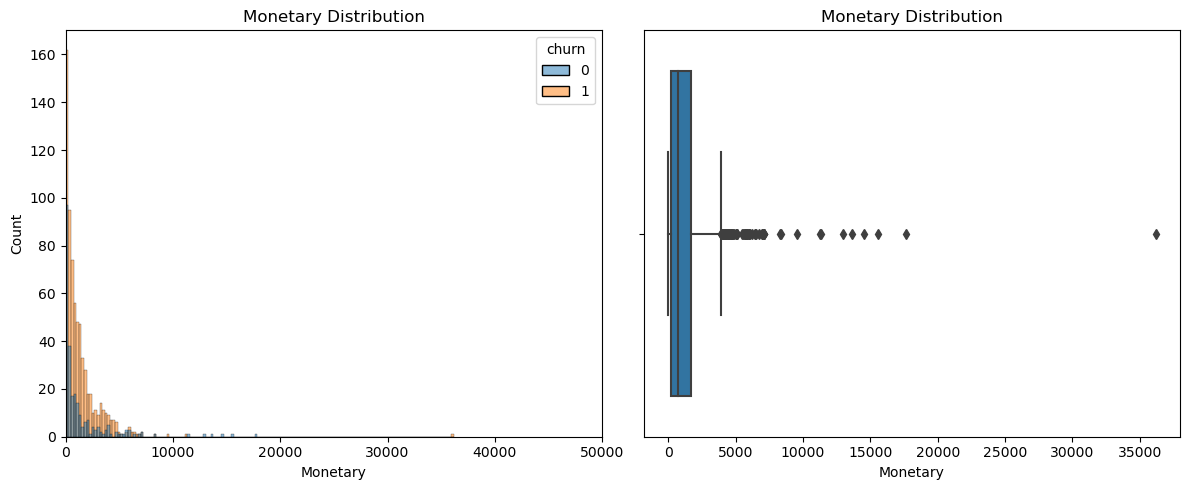

In [178]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Monetary Distribution
sns.histplot(eda_rfm_data, x='Monetary', hue='churn', bins=150, ax=axes[0])
axes[0].set_title('Monetary Distribution')
axes[0].set_xlim(0, 50000)

# Plot 2: Boxplot
sns.boxplot(x='Monetary', data=eda_rfm_data, ax=axes[1])
axes[1].set_title('Monetary Distribution')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

- There are outliers in monetary

### AOV

In [179]:
# describe
eda_rfm_data['AOV'].describe()

count    950.000000
mean     119.730474
std       85.610076
min        1.000000
25%       56.425000
50%      112.500000
75%      166.252500
max      851.000000
Name: AOV, dtype: float64

Text(0.5, 1.0, 'AOV Distribution')

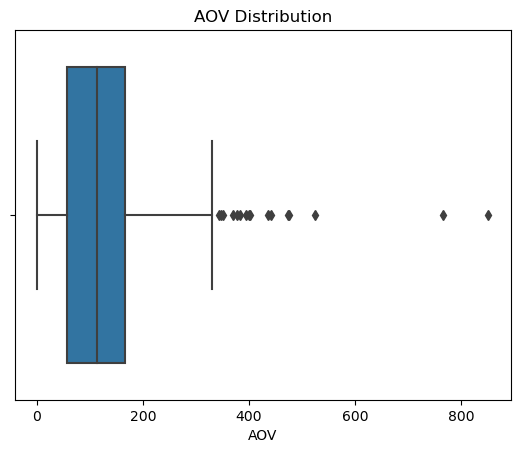

In [180]:
# Plot : Boxplot
sns.boxplot(x='AOV', data=eda_rfm_data)
plt.title('AOV Distribution')

- We can also see the outliers in AOV

### Response Variable: Churn

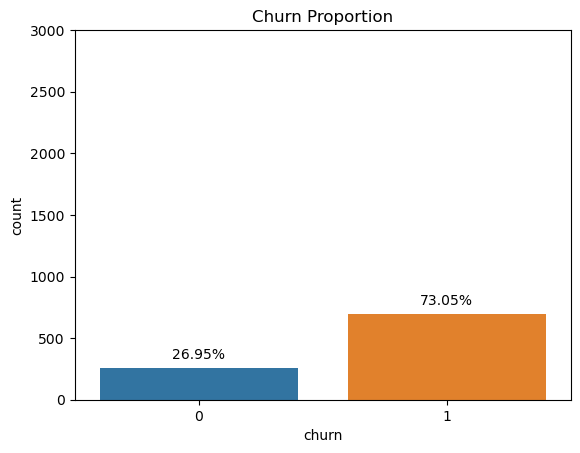

In [181]:
# Generate the countplot
ax = sns.countplot(data=eda_rfm_data, x='churn',
                   order=eda_rfm_data['churn'].value_counts().index[::-1])

# Calculate the percentage of each category
churn_counts = eda_rfm_data['churn'].value_counts(normalize=True)
churn_percentage = np.round(churn_counts * 100, 2)

# Add count annotations to each bar
for p, percentage in zip(ax.patches, churn_percentage[::-1]):
    ax.annotate(f"{percentage}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# set y limit
plt.ylim(0,3000)

# Set plot title
plt.title('Churn Proportion')

# Show the plot
plt.show()

In [190]:
# Split data original
df_join = df.loc[df['transaction_date'] <= '2019-08-28']

In [191]:
# Sanichek
print(df_join.shape)
df_join.head()

(12764, 21)


,transaction_id,customerid,gender,location,tenure_months,transaction_date,product_sku,product_description,product_category,quantity,...,delivery_charges,coupon_status,gst,offline_spend,online_spend,coupon_code,discount_pct,Month,CohortMonth,CohortIndex
1,36286,17965,F,Chicago,7,2019-08-22,GGOEGOCB017499,Leatherette Journal,Office,30,...,61.13,Used,0.10,2500,1172,OFF20,20.00,2019-08-01,2019-03-01,6
2,36320,13488,F,California,22,2019-08-22,GGOEGOLC014299,Google Metallic Notebook Set,Office,40,...,85.33,Used,0.10,2500,1172,OFF20,20.00,2019-08-01,2019-03-01,6
3,36323,13488,F,California,22,2019-08-22,GGOEGFKQ020799,Google Doodle Decal,Office,300,...,50.93,Clicked,0.10,2500,1172,OFF20,20.00,2019-08-01,2019-03-01,6
4,36334,13488,F,California,22,2019-08-22,GGOEGGOA017399,Maze Pen,Office,50,...,6.00,Clicked,0.10,2500,1172,OFF20,20.00,2019-08-01,2019-03-01,6
5,36233,13458,F,California,33,2019-08-22,GGOEGOCB017499,Leatherette Journal,Office,8,...,21.19,Not Used,0.10,2500,1172,OFF20,20.00,2019-08-01,2019-06-01,3


In [192]:
# Save data churn
merge_churn = pd.merge(eda_rfm_data, df_join, on='customerid', how='inner')

In [200]:
# Total churn
total_churn = (merge_churn['churn'] == 1).sum()
total_no_churn = (merge_churn['churn'] == 0).sum()

In [202]:
# Total
print("Customer Churn", total_churn)
print("Customer unchurn", total_no_churn)

Customer Churn 8698
Customer unchurn 4066


In [195]:
# Save to csv
merge_churn.to_csv('D:\Project_Data\project\Project Pribadi\Cohort and Churn Analysis\Data Churn.csv', index=False)